# AI supported Time-Series Analysis

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

%matplotlib qt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})
# return the name of the device, which can be cuda (GPU) or cpu
print(torch.cuda.get_device_name() if torch.cuda.is_available() else 'cpu')


cpu


## NeuNet Class

In [3]:
class NeuNet(object):                                                               # to the class we shall provide a model, a loss_fn and an optimizer.
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)                                                  # here we send the model to the device

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):                                                           # this is the function sending the model to the device
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):                           # data loaders provide the input data in a sutiable format to the model, in a minibatch size
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer
        
        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()                                                      # the model has a different behaviour during training and evaluation mode

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()                                              # avoid cumulation of gradients

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn
    
    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()                                                       # here we set the model to evaluation mode

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, 
            # since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn
            
    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and 
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None
            
        # Once the data loader and step function, this is the 
        # same mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def train(self, n_epochs, seed=42):                                             # this function execute the training of the model
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in tqdm(range(n_epochs)):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:                                                         # this is optional, i.e. Tensorboard output
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training   

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))                                 # sending input to device
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()                                          # sending back to cpu for return

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b', lw=1)
        plt.plot(self.val_losses, label='Test Loss', c='r', lw=1)
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))


# Pytorch Neural Network 

## Loading and Transforming Data

In [4]:
#PATH = r"C:\Users\IFE497\OneDrive - ENGIE\DATA_GE1021\DATA\CODES\AI4PS\SimBench\output\engine_database.csv"

PATH_O = r".\file\output\SimBench\engine_database.csv"
PATH_I = r".\file\input\SimBench\network_with_gen.csv" 

df = pd.read_csv(PATH_O, sep=",", index_col=[0, 1, 2, 3, 4])
df_I = pd.read_csv(PATH_I, sep=";", decimal=",")
temp_df = df_I.copy()
arr = temp_df.to_numpy()
df_I = pd.DataFrame(np.tile(arr, (240, 1)), columns = temp_df.columns)

In [5]:
df.index

MultiIndex([(0,   0, 'in_service',    'bus',  'EHV Bus 1865'),
            (0,   0, 'in_service',    'bus',  'EHV Bus 1866'),
            (0,   0, 'in_service',    'bus',  'EHV Bus 3092'),
            (0,   0, 'in_service',    'bus',  'EHV Bus 3093'),
            (0,   0, 'in_service',    'bus',  'EHV Bus 3094'),
            (0,   0, 'in_service',    'bus',     'HV2 Bus 1'),
            (0,   0, 'in_service',    'bus',    'HV2 Bus 10'),
            (0,   0, 'in_service',    'bus',   'HV2 Bus 100'),
            (0,   0, 'in_service',    'bus',   'HV2 Bus 101'),
            (0,   0, 'in_service',    'bus',   'HV2 Bus 102'),
            ...
            (1, 239,     'closed', 'switch', 'HV2 Switch 93'),
            (1, 239,     'closed', 'switch', 'HV2 Switch 94'),
            (1, 239,     'closed', 'switch', 'HV2 Switch 95'),
            (1, 239,     'closed', 'switch', 'HV2 Switch 96'),
            (1, 239,     'closed', 'switch', 'HV2 Switch 97'),
            (1, 239,     'closed', 'swi

In [6]:
X_df = df.loc[:,:,"in_service","line",:,:].stack().unstack("id")
number_of_lines = len(set(X_df.columns)) # number of lines
df_I.index= X_df.index
X_df = pd.concat([X_df, df_I], axis=1)
y_df = df.loc[:,:,"loss_of_load_p_mw","load",:,:].stack().unstack("id")
ysum_df = pd.DataFrame(y_df.sum(axis=1))

Generating Features and Target Variables

In [28]:
%%writefile ./v0.py
#from sklearn.model_selection import StratifiedShuffleSplit
# loading data from previous script
from collections import Counter
#X = np.load("X.npy") 
#y = np.load("y.npy")
#number_of_lines = len(set(X_df_t.columns)) # number of lines
X = X_df.to_numpy()
y = ysum_df.to_numpy()
z = pd.DataFrame(X).iloc[:,:number_of_lines].astype(int).astype(str).sum(axis=1) # labels in str form
# sum(axis=1) gives different behaviour, dependent on python version (as it seems)

l = [] #  list
c = Counter(z)
for k in z:
    #print(k)
    if c[k] == 1:
        l.append(str('G0'))
    else:
        l.append(str(k))


# 1104 G0 values        
#Split data Model ANN 1
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.1, stratify = pd.DataFrame(l)[0], shuffle=True, random_state=42)
    
##Split data Model ANN2
# X_train, X_val, y_train, y_val = train_test_split(X[(np.array(l) != "G0")], y[(np.array(l) != "G0")], train_size=0.1, stratify = pd.DataFrame(l)[(np.array(l) != "G0")][0], shuffle=True,random_state=42)
# X_train = np.append(X_train, X[(np.array(l) == "G0")],axis=0)
# y_train = np.append(y_train, y[(np.array(l) == "G0")], axis=0)

#Split data Model ANN 3
# X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.1,  
#                                                 shuffle=True, random_state=42)

# standardize data
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train = np.concatenate((X_train.T[:number_of_lines].T, scaler_x.fit_transform(X_train.T[number_of_lines:].T)), axis=1).astype(float)
X_val = np.concatenate((X_val.T[:number_of_lines].T, scaler_x.transform(X_val.T[number_of_lines:].T)), axis=1).astype(float)# without fit!
y_train = scaler_y.fit_transform(y_train).astype(float)
y_val = scaler_y.transform(y_val).astype(float)


Overwriting ./v0.py


In [34]:
%run -i ./v0.py

In [38]:
z_train = pd.DataFrame(X_train).iloc[:,:number_of_lines].astype(int).astype(str).sum(axis=1) # labels in str form
l_train = [] #  list
c_train = Counter(z_train)
for k in z_train:
    #print(k)
    l_train.append(k)
len(set(l_train))

162

In [39]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,224,225,226,227,228,229,230,231,232,233
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.533509,0.533509,0.533509,0.533509,0.533509,0.624989,0.624989,0.624989,0.733392,0.733392
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.169709,0.169709,0.169709,0.169709,0.169709,0.111992,0.111992,0.111992,0.108437,0.108437
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.786730,0.786730,0.786730,0.786730,0.786730,0.869064,0.869064,0.869064,0.783368,0.783368
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.613120,-1.613120,-1.613120,-1.613120,-1.613120,-1.408910,-1.408910,-1.408910,-1.340395,-1.340395
4,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.662655,0.662655,0.662655,0.662655,0.662655,0.132237,0.132237,0.132237,-0.014611,-0.014611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,-1.302245,-1.302245,-1.302245,-1.302245,-1.302245,-1.258844,-1.258844,-1.258844,-1.217892,-1.217892
1196,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.786687,0.786687,0.786687,0.786687,0.786687,0.206280,0.206280,0.206280,0.076080,0.076080
1197,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.982055,0.982055,0.982055,0.982055,0.982055,0.979052,0.979052,0.979052,0.898682,0.898682
1198,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.292958,1.292958,1.292958,1.292958,1.292958,1.230984,1.230984,1.230984,1.195657,1.195657


## Model Preparation

In [50]:
%%writefile ./v2.py

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter


torch.manual_seed(555)

# Builds tensors from numpy arrays BEFORE split
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_train_tensor = torch.from_numpy(y_train).float()
y_val_tensor = torch.from_numpy(y_val).float()


# Builds dataset containing ALL data points

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = []
val_loader = []

# from sklearn.model_selection import KFold


# # K-fold Cross Validation model evaluation
# kfold = KFold(n_splits=5, shuffle=True)
# for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset_train)):

#     # Print
#     print(f'FOLD {fold}')
#     print('--------------------------------')

#     # Sample elements randomly from a given list of ids, no replacement.
#     train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
#     test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

#     # Define data loaders for training and testing data in this fold
#     train_loader.append(torch.utils.data.DataLoader(
#                       dataset_train, 
#                       batch_size=256, sampler=train_subsampler))
#     val_loader.append(torch.utils.data.DataLoader(
#                       dataset_train,
#                       batch_size=256, sampler=test_subsampler))

   
train_loader.append(DataLoader(dataset=dataset_train, batch_size=256, shuffle=True)) #batch_size=256
val_loader.append(DataLoader(dataset=dataset_val, batch_size=256))

Writing ./v2.py


In [51]:
%run -i ./v2.py

## Model Configuration

In [52]:
%%writefile ./v3.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.001

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(X_train.shape[1], 512), nn.ReLU(),
                      #nn.Dropout(p=0.1),
                      nn.Linear(512, 512), nn.ReLU(),
                      nn.Linear(512, 512), nn.ReLU(),
                      nn.Linear(512,512), nn.ReLU(),
                      nn.Linear(512, 256), nn.ReLU(),
                      nn.Linear(256, y_train.shape[1]) ).to(device)

# Defines an  optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')




Writing ./v3.py


In [53]:
%run -i ./v3.py

## Model Instantiation

In [54]:
neunet = NeuNet(model, loss_fn, optimizer)
neunet.set_loaders(train_loader[0], val_loader[0])
neunet.set_tensorboard(name="runs", folder = 'machine_learning_tutorial/Test_Grid10')

In [55]:
print(neunet.model)

Sequential(
  (0): Linear(in_features=234, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=512, bias=True)
  (7): ReLU()
  (8): Linear(in_features=512, out_features=256, bias=True)
  (9): ReLU()
  (10): Linear(in_features=256, out_features=1, bias=True)
)


## Model Training

In [56]:
neunet.train(n_epochs = 500)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [03:15<00:00,  2.56it/s]


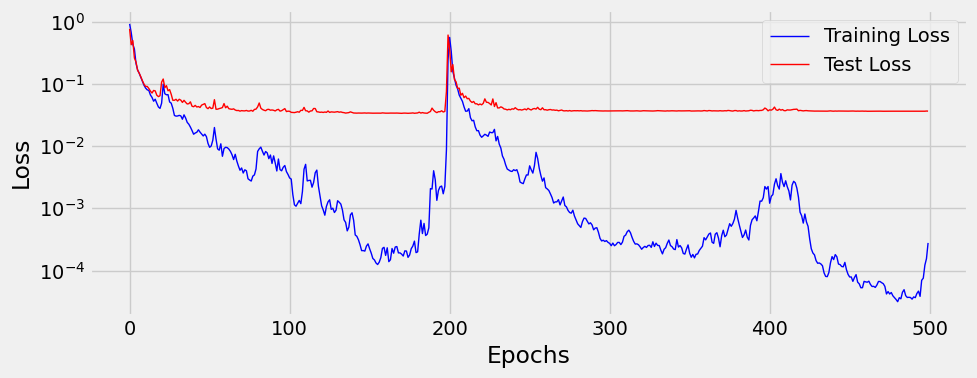

In [57]:
%matplotlib inline
plt.style.use('fivethirtyeight')
fig = neunet.plot_losses()

In [58]:
print(neunet.val_losses[-1])
print(neunet.losses[-1])

0.036416869393961375
0.00027785422425949944


# TensorBoard

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir machine_learning_tutorial/Test_Grid10

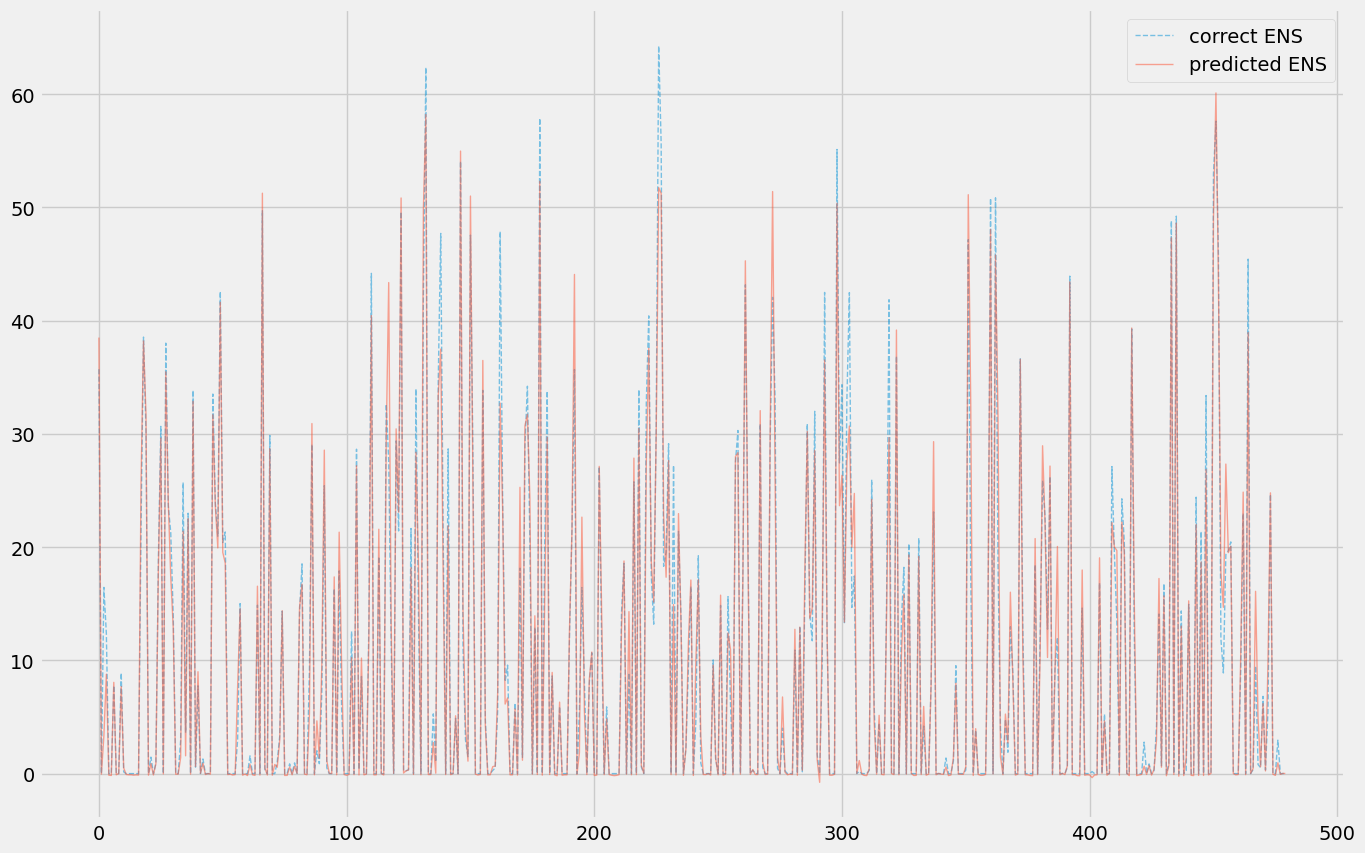

MSE = 0.03620007778599569
Normalized MSE = 0.00046876930924530304
ENSError = 0.01832205329409939


In [61]:
# prediction of validation points
i = 0
start_t = 50
end_t = start_t + 24*4*5
#new_inputs = torch.tensor(X_val).float()
new_inputs = np.array(X_val)
model.eval()
#pred = model(new_inputs.to(device))
pred = neunet.predict(new_inputs)
orig = y_val
f, (ax) = plt.subplots(1,1, figsize=(15, 10)) 
plt.plot(scaler_y.inverse_transform(orig)[start_t:end_t, i], alpha=.5, linestyle="--", label="correct ENS", lw=1)
plt.plot(scaler_y.inverse_transform(pred)[start_t:end_t, i], alpha=.5, linestyle="-", label="predicted ENS", lw=1)
plt.legend()
plt.show()
MSE = np.mean(scaler_y.inverse_transform(orig)- scaler_y.inverse_transform(pred))**2
print(f"MSE = {MSE}")
print(f"Normalized MSE = {MSE/(scaler_y.inverse_transform(orig).max()-scaler_y.inverse_transform(orig).min())}")
print(f"ENSError = {abs((scaler_y.inverse_transform(pred).mean() - scaler_y.inverse_transform(orig).mean()))/scaler_y.inverse_transform(orig).mean()}")

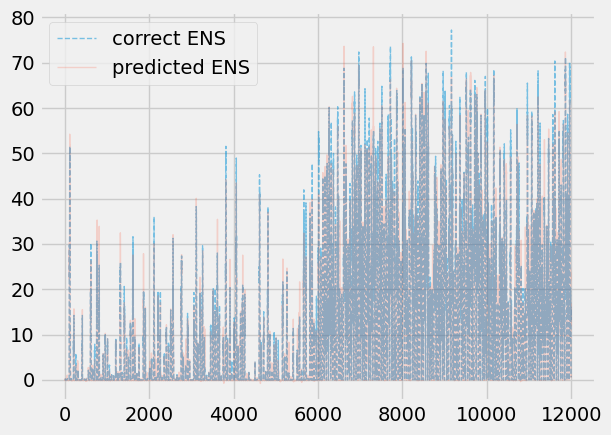

MSE = 1.1013350542948272e-05
MSEP = 1.056040210943147e-06
ENSError = 0.0003182346236979373


In [74]:
# prediction of time series sequences
new_inputs = np.concatenate((X.T[:number_of_lines].T, scaler_x.transform(X.T[number_of_lines:].T)), axis=1).astype(float)

model.eval()
#pred = model(new_inputs.to(device))
pred = neunet.predict(new_inputs)
orig = scaler_y.transform(y)
plt.plot(scaler_y.inverse_transform(orig), alpha=.5, linestyle="--", label="correct ENS", lw=1)
plt.plot(scaler_y.inverse_transform(pred), alpha=.2, linestyle="-", label="predicted ENS", lw=1)
plt.legend()
plt.show()
print(f"MSE = {np.mean(scaler_y.inverse_transform(orig)- scaler_y.inverse_transform(pred))**2}")
print(f"MSEP = {(np.mean(scaler_y.inverse_transform(orig)- scaler_y.inverse_transform(pred))**2)/np.mean(scaler_y.inverse_transform(orig))}")
print(f"ENSError = {abs((scaler_y.inverse_transform(pred).mean() - scaler_y.inverse_transform(orig).mean()))/scaler_y.inverse_transform(orig).mean()}")

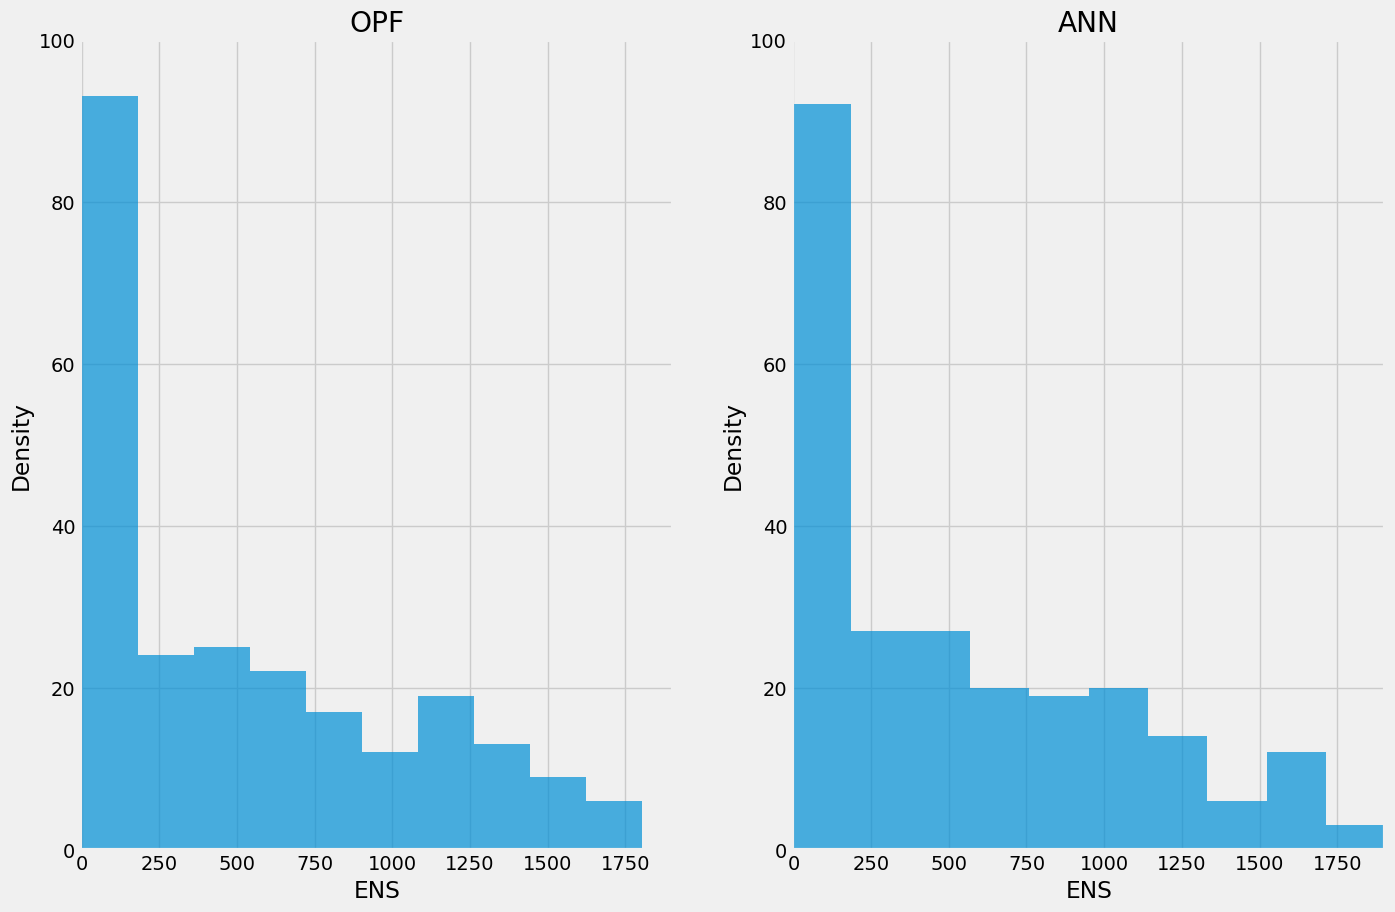

In [75]:

ENSp = np.full((int(len(y)/50), 1), np.nan)
ENSo = np.full((int(len(y)/50), 1), np.nan)
for i, k in enumerate(range(0, len(X), 50), start=0):
    #print(k)
    ENSp[i] = scaler_y.inverse_transform(pred[k:(k+50)]).sum()
    ENSo[i] = scaler_y.inverse_transform(orig[k:(k+50)]).sum()

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
ax1.set_xlim(min(np.concatenate([ENSo, ENSp])), max(np.concatenate([ENSo, ENSp])))
ax1.set_ylim(0, 100)
ax2.set_ylim(0, 100)
ax2.set_xlim(min(np.concatenate([ENSo, ENSp])), max(np.concatenate([ENSo, ENSp])))
#ax1.set_ylim([ymin, ymax])
ax1.hist(ENSo, alpha = 0.7)
ax1.set_xlabel("ENS")
ax1.set_ylabel("Density")
ax1.set_title("OPF")
ax2.hist(ENSp, alpha = 0.7)
ax2.set_xlabel("ENS")
ax2.set_ylabel("Density")
ax2.set_title("ANN")
plt.show()

In [76]:
from scipy.stats import kurtosis, skew
print(f"mean ENS predicted = {ENSp.mean()}")
print(f"mean ENS original = {ENSo.mean()}")
print(f"median ENS predicted = {np.median(ENSp)}")
print(f"median ENS original = {np.median(ENSo)}")
print(f"standard deviation ENS predicted = {ENSp.std()}")
print(f"standard deviation ENS original = {ENSo.std()}")
print(f"kurtosis ENS predicted: {kurtosis(ENSp)}")
print(f"kurtosis ENS original: {kurtosis(ENSo)}")
print(f"skeweness ENS predicted: {skew(ENSp)}")
print(f"skeweness ENS original: {skew(ENSo)}")

mean ENS predicted = 521.6115393576523
mean ENS original = 521.4456054240717
median ENS predicted = 391.9841613769531
median ENS original = 380.0086413605373
standard deviation ENS predicted = 507.60258024573056
standard deviation ENS original = 511.4371312030292
kurtosis ENS predicted: [-0.56620511]
kurtosis ENS original: [-0.58797646]
skeweness ENS predicted: [0.75579858]
skeweness ENS original: [0.76617784]


# Survivability

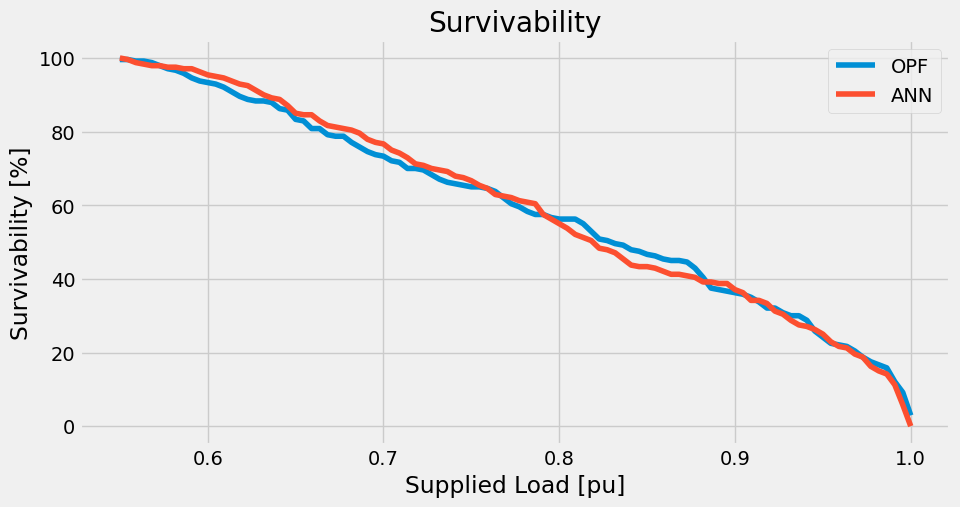

In [77]:
MaxLoad = df_I.iloc[:,42:].sum(axis=1).max()
#MaxLoad = 173.54 #MW (from analysed time series)
crit_load_pu = np.linspace(0,0.45,100)
crit_load = crit_load_pu*MaxLoad
Sp = []
So = []
for i, k in enumerate(range(0, len(X), 50), start=0):
    #print(k)
    Sp.append(scaler_y.inverse_transform(pred[k:(k+50)]).T[0])
    So.append(scaler_y.inverse_transform(orig[k:(k+50)]).T[0])
Sp = np.array(Sp)
So = np.array(So)

q = 1 # quantile deciding the maximum loss of load
#df.iloc[:,5:][(df.type == "load") & (df.field == "max_p_mw")].sum(axis=1).max() # max load
surv_p = np.full(len(crit_load), np.nan)
surv_o = np.full(len(crit_load), np.nan)
for i, c in enumerate(crit_load):
    #surv_p[i] = (Sp.max(axis=1) < c).sum()/240
    surv_p[i] = (np.quantile(Sp, q, axis=1) < c).sum()/240
    #surv_o[i] = (So.max(axis=1) < c).sum()/240
    surv_o[i] = (np.quantile(So, q, axis=1) < c).sum()/240
#plt.plot((1-crit_load_pu), surv)
f, (ax1) = plt.subplots(1,1, figsize=(10, 5))
ax1.plot((1-crit_load_pu), surv_o*100)
ax1.set_xlabel("Supplied Load [pu]")
ax1.set_ylabel("Survivability [%]")
ax1.set_title("Survivability")
ax1.plot((1-crit_load_pu), surv_p*100)
ax1.legend(["OPF", "ANN"], loc ="upper right")
plt.show()

In [78]:
Sp.max(axis=1).shape

(240,)

In [79]:
Sp

array([[-1.24533735e-02,  2.60884203e-02, -2.85981260e-02, ...,
        -5.60906492e-02,  5.57639040e-02,  3.76717485e-02],
       [-1.24533735e-02,  1.04434676e-01,  2.85813250e-02, ...,
        -5.60906492e-02,  5.57639040e-02,  3.76717485e-02],
       [-1.24533735e-02,  8.88237858e+00,  1.20721216e+01, ...,
        -5.60906492e-02,  5.57639040e-02,  3.76717485e-02],
       ...,
       [-1.24533735e-02,  1.55576849e+01,  1.80386505e+01, ...,
         7.99323750e+00,  5.97331190e+00,  5.05924940e+00],
       [-1.24533735e-02,  5.16252613e+00,  1.02236147e+01, ...,
         3.97722650e+00,  1.60321307e+00,  1.15424609e+00],
       [-1.24533735e-02,  5.29387045e+00,  1.49405851e+01, ...,
         5.75975120e-01,  8.69773567e-01,  5.76229751e-01]], dtype=float32)

# Checkpointing

In [67]:
neunet.save_checkpoint('model_checkpoint.pth')

## Resuming Training

In [80]:
%run -i ./v0.py
%run -i ./v3.py

<Figure size 640x480 with 0 Axes>

In [81]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[ 0.0500,  0.0543, -0.0153,  ...,  0.0487,  0.0314,  0.0550],
        [ 0.0342,  0.0165, -0.0006,  ..., -0.0334, -0.0543, -0.0357],
        [ 0.0630,  0.0559,  0.0585,  ...,  0.0601,  0.0396, -0.0306],
        ...,
        [ 0.0228, -0.0424,  0.0031,  ..., -0.0593,  0.0610, -0.0246],
        [ 0.0311,  0.0302, -0.0479,  ...,  0.0174,  0.0617,  0.0613],
        [ 0.0110, -0.0366, -0.0040,  ...,  0.0263, -0.0038, -0.0114]])), ('0.bias', tensor([-4.3430e-02, -6.0828e-02,  4.1208e-02, -1.5307e-02,  3.7184e-02,
         5.8217e-02,  5.1147e-02,  2.5168e-02,  1.7763e-04, -1.8405e-02,
        -3.5755e-02, -5.2136e-02,  6.4332e-02, -8.0700e-03, -1.4436e-02,
        -5.8049e-02, -5.4985e-03, -1.6627e-02,  5.7506e-02,  3.8949e-03,
         5.2703e-02,  2.1511e-02, -3.4302e-02, -5.9490e-02,  2.1699e-02,
        -1.4129e-02, -4.3173e-03, -9.2313e-03, -2.8163e-02,  6.4078e-02,
        -2.6725e-02,  3.4249e-02, -5.1347e-02, -3.1538e-05, -2.6546e-02,
         5.9540e

In [82]:
new_neunet = NeuNet(model, loss_fn, optimizer)

In [83]:
new_neunet.load_checkpoint("model_checkpoint.pth")

In [84]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[ 0.0975,  0.0945, -0.0405,  ...,  0.0604,  0.0483,  0.0719],
        [ 0.0346,  0.0134, -0.0038,  ..., -0.0303, -0.0512, -0.0325],
        [ 0.0499,  0.0428,  0.0457,  ...,  0.0619,  0.0425, -0.0277],
        ...,
        [ 0.0344, -0.0371, -0.0556,  ..., -0.0621,  0.0601, -0.0254],
        [ 0.0227,  0.0221, -0.0570,  ...,  0.0116,  0.0552,  0.0548],
        [ 0.0075, -0.0497, -0.0140,  ...,  0.0278, -0.0025, -0.0101]])), ('0.bias', tensor([-4.8642e-02, -6.4022e-02,  2.8082e-02, -2.4446e-02,  4.6268e-02,
         4.8874e-02,  4.0562e-02,  1.4077e-02, -6.5047e-03, -2.7288e-02,
        -3.2381e-02, -5.2258e-02,  5.7791e-02, -1.4139e-02, -2.0281e-02,
        -6.7407e-02, -1.7636e-02, -2.2741e-02,  5.3100e-02, -2.0805e-03,
         6.1342e-02,  6.9020e-03, -5.3025e-02, -5.0474e-02,  8.7506e-03,
        -2.3386e-02, -9.9139e-03, -5.6342e-03, -2.0960e-02,  5.3774e-02,
        -3.1210e-02,  2.2367e-02, -5.9626e-02, -3.1538e-05, -2.9136e-02,
         5.8115e

In [85]:
new_neunet.set_loaders(train_loader[0], val_loader[0])
new_neunet.train(n_epochs=10)

100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


### Plot losses of resumed model

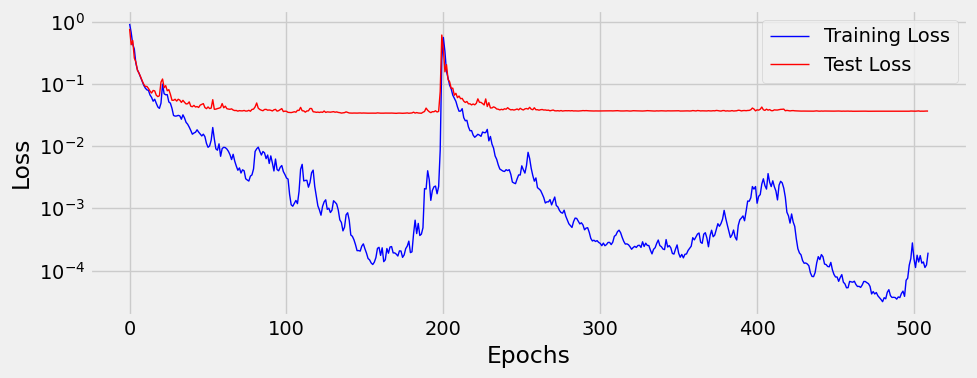

In [86]:
fig = new_neunet.plot_losses()